<p align="center">
  <img src="img/image_principal.jpg" width="1000" title="img-principal">
</p>

# CONTEXTO DO PROBLEMA

A **Rossmann** é uma das maiores redes de drogarias da Europa, com cerca de 56.200 funcionários e mais de 4.000 lojas. Em 2019, a Rossmann faturou mais de € 10 bilhões na Alemanha, Polônia, Hungria, República Tcheca, Turquia, Albânia, Kosovo e Espanha.

A gama de produtos inclui até 21.700 itens e pode variar dependendo do tamanho da loja e da localização. Além de produtos de drogaria com foco em pele, cabelo, corpo, bebê e saúde, a Rossmann também oferece itens promocionais ("Mundo das Ideias"), pet food, serviço de fotos e uma ampla variedade de alimentos e vinhos naturais. Existe também uma gama de perfumes com cerca de 200 marcas comerciais. A Rossmann tem 29 marcas próprias com 4600 produtos (a partir de 2019). Em 1997 foram introduzidas as primeiras marcas próprias Babydream, Facelle, Sunozon e Winston. 

# O PROBLEMA

Por se tratar de uma rede grande e de muito sucesso, os CFO e os diretos fazem muitas reuniões para acompanhemento e melhorias nas lojas da rede. Entre uma dessas reuniões, foi levantado que é hora de realizar uma reforma nas lojas, pensando nisso, o CFO da empresa fez uma reunião com todos os Gerentes de Loja e pediu para que cada um deles trouxessem uma previsão das próximas 6 semanas de vendas com o objetivo de determinar o budget para a reforma. 

Após a reunião, os gerentes levaram o desafio ao time de ciencia de dados para criar um modelo que é capaz de prever as vendas das próximas 6 semanas.

# ENTENDIMENTO DO PROBLEMA

**Motivação:**
  - A previsão de vendas foi requisitada pelo CFO em uma reunião mensal sobre os resultados das lojas.
   
**Causa do Raiz do Problema:**
   - Dificuldade em determinar o valor do investimento para Reformas de cada Loja.
    
**Quem é o Stakeholder:**
   - Diretor Financeiro (CFO) da Rossmann.
    
**Formato da Solução:**
   - **Granularidade:** Previsão de vendas por Dia da Loja pra os próximos 42 dias, 6 semanas.
   - **Tupo de Problema:** Previsão de Vendas.
   - **Potênciais Métodos:** Séries Temporais, Regressão.
   - **Formato da Entrega:** O valor das Vendas no final de cada 6º semana. E acesso as vendas através do Celular.

# 0.0 IMPORTS

In [1]:
# Manipulation and math
import pandas as pd
import numpy as np
import inflection
import datetime
from scipy import stats
import random

# Visualization
import seaborn as sns 
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb
import pickle

# Metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 0.1 Funções Auxiliares

In [7]:
# correlation categories
def cramer_v(x, y):
    
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2_corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    
    kcorr = k - (k-1) **2 / (n-1)
    rcorr = r - (r-1) **2 / (n-1)
    
    return np.sqrt((chi2_corr / n) / (min(kcorr-1, rcorr-1)))


# Show matrix correlation
def show_matrix(col, data, output='list'):

    rows = []
    index = []
    columns = []

    for c in data.columns:

        result = cramer_v(x=data[str(col)], y=data[str(c)])

        rows.append(result)
        index.append(str(c))
        columns.append(str(col))
        
    if output == 'list':
        return rows
    
    elif output == 'dict':
        return pd.DataFrame(rows, index=index, columns=[str(col)])
    

# Calculate metrics Machine Learning model
def ml_error(model_name, y, yhat):
    
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])


# Calculate metric mpe to model
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y )


# Function to do cross validation on the dataset
def cross_validation(x_training, kfold, model_name, model, verbose=False):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        
        if verbose:
            print('KFold Number:', k)
            
        # Start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*7)

        # Filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # Training 
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # Validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # Model
        m = model.fit(xtraining, ytraining)

        # Prediction
        yhat = m.predict(xvalidation)

        # Performance
        m_result = ml_error(str(model_name), np.expm1(yvalidation), np.expm1(yhat))

        # Store performance of each KFold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    dataframe = pd.DataFrame(
        {'Model Name': model_name,
         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0]
    )
    
    return dataframe

## 0.2 Carregamento de Dados

In [2]:
df_sales = pd.read_csv('data/train.csv', low_memory=False) # loading data1
df_store = pd.read_csv('data/store.csv', low_memory=False) # loadind data2

# merge data1 and data2
df_raw = pd.merge(df_sales, df_store, how='left', on='Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 DESCRIÇÃO DE DADOS

## 1.1 Dimensão de Dados

In [12]:
row = df_raw.shape[0]
col = df_raw.shape[1]

print(f'Número de Linhas: {row}')
print(f'Número de Colunas: {col}')

Número de Linhas: 1017209
Número de Colunas: 18


## 1.2 Tipo de Dados

In [13]:
df_raw['Date'] = pd.to_datetime(df_raw['Date']) # Parse column date to Datetime
df_raw.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

## 1.3 Verificação de Dados Faltantes

In [33]:
df_raw.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

## 1.4 Renomeação de Colunas

In [34]:
# Parse columns to snakecase
cols_old = list(df_raw.columns)

snakeCase = lambda x: inflection.underscore(x)
cols_new = list(map(snakeCase, cols_old))

df_raw.columns = cols_new
df_raw.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.5 Tratamento de Dados Faltantes

In [35]:
# -- competition_distance
df_raw['competition_distance'] = df_raw['competition_distance'].apply(lambda x: 200000.0 if pd.isnull(x) else x)


# -- competition_open_since_month
df_raw['competition_open_since_month'] = df_raw[['date', 'competition_open_since_month']].apply(lambda x: x['date'].month if pd.isnull(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)


# -- competition_open_since_year 
df_raw['competition_open_since_year'] = df_raw[['date', 'competition_open_since_year']].apply(lambda x: x['date'].year if pd.isnull(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


# -- promo2_since_week
df_raw['promo2_since_week'] = df_raw[['date', 'promo2_since_week']].apply(lambda x: x['date'].week if pd.isnull(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


# -- promo2_since_year  
df_raw['promo2_since_year'] = df_raw[['date', 'promo2_since_year']].apply(lambda x: x['date'].year if pd.isnull(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


# -- promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df_raw['promo_interval'].fillna(0, inplace=True)
df_raw['month_map'] = df_raw['date'].dt.month.map(month_map)

df_raw['is_promo'] = df_raw[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


# Show NaN
df_raw.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Mudança de Tipo nos Dados

In [36]:
# competition_open_since_month
df_raw['competition_open_since_month'] = df_raw['competition_open_since_month'].astype('int64')


# competition_open_since_year
df_raw['competition_open_since_year'] = df_raw['competition_open_since_year'].astype('int64')


#cpromo2_since_week
df_raw['promo2_since_week'] = df_raw['promo2_since_week'].astype('int64')


# promo2_since_year
df_raw['promo2_since_year'] = df_raw['promo2_since_year'].astype('int64')

## 1.7 Estatistica Descritiva

### 1.7.1 Atributos Numéricos

In [37]:
num_attributes = df_raw.select_dtypes(include=['int64', 'float64'])

describe = num_attributes.describe().T

# Add Kutsosis and Skew
describe['skews'] = num_attributes.apply(lambda x: x.skew()) 
describe['kurtosis'] = num_attributes.apply(lambda x: x.kurtosis()) 

describe

,count,mean,std,min,25%,50%,75%,max,skews,kurtosis
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0,-0.000955,-1.200524
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0,0.001593,-1.246873
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0,0.641460,1.778375
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0,1.598650,7.091773
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0,-1.758045,1.090723
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0,0.487838,-1.762018
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0,1.677842,0.815154
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0,10.242344,147.789712
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0,-0.042076,-1.232607
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0,-7.235657,124.071304


**Insight:**

<ins>Distribuição</ins>: As vendas das lojas variam em torno de 3.849 Mil e estão mais dispersas em relação com a mediana ou a média e possui uma skew próxima de 0 e kurtosis próxima de 1, o que indica estar próxima de uma distribuição normal e com um pico grande. Sobre a distancia dos competidores, há também maior dispersão, possuindo uma skew e kutorsis bem altas mostrando estar longe de uma distribuição normal.


<ins>Negócio</ins>: A menor quantidade de vendas foi 0, provavelmnete em dia que se manteve fechada e a maior quantidade foi 41 Mil em vendas. Sobre a competição, o competidore mais próximo está a 20 metros e o mais longe a 200 Mil metros. Há também promoções que foram estendidas que começaram desde 2009 e em média 633 clientes que curcualam na loja.

### 1.7.2 Atributos Categóricos

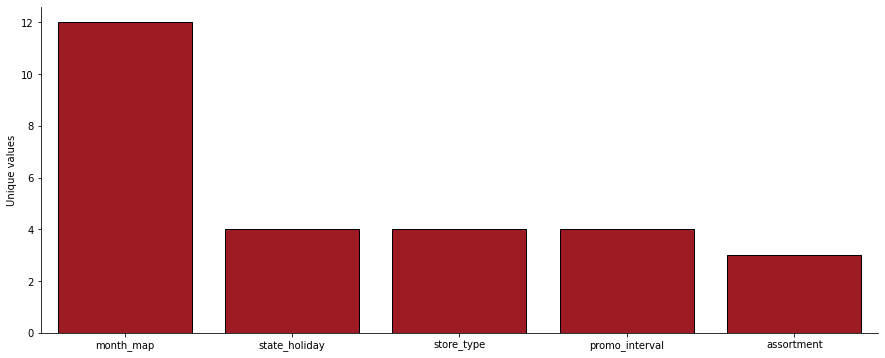

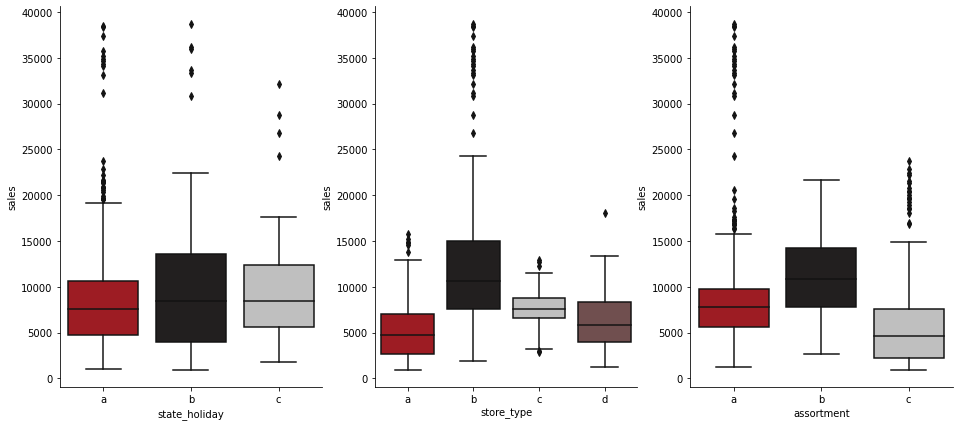

In [38]:
# Filter Categories
cat_attributes = df_raw.select_dtypes(include=['object']) 

# Figure 1
unique_values = cat_attributes.apply(lambda x: len(x.unique())).sort_values(ascending=False)
plt.figure(figsize=(15, 6))
sns.barplot(x=unique_values.index, y=unique_values.values, color='#b20710', ec='k')
plt.ylabel('Unique values')
sns.despine(right=True)

# Figure 2
filter_zero = df_raw[(df_raw['state_holiday'] != '0') & (df_raw['sales'] > 0)]
plt.figure(figsize=(16, 7))
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=filter_zero, palette=['#b20710', '#221f1f', '#bfbfbf', '#754a4a'])
sns.despine(right=True)

# Figure 3
plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=filter_zero, palette=['#b20710', '#221f1f', '#bfbfbf', '#754a4a'], order=['a', 'b', 'c', 'd'])
sns.despine(right=True)

# Figure 4
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=filter_zero, palette=['#b20710', '#221f1f', '#bfbfbf'], order=['a', 'b', 'c'])
sns.despine(right=True);

**Insight:**

<ins>Distribuição</ins>: As variaveis categóricas possuem entre 3 e 12 possíveis valores. Feriados do tipo B possuem vendas mais distribuidas e feriado tipo A tem maior quantidade de vendas com valores extremos. Tipo de loja B também há maior distribuição nas vendas e tipo C obtem menor. Em assortment, tipo B possui vendas mais distribuidas e no tipo A tem maior quantidade de vendas extremas.

<ins>Negócio</ins>: Em feriados estudais do tipo B, tem maior cocentração de vendas entre 5 Mil e 13 Mil. Já em tipo de loja, o tipo B possui maior concentração das vendas entre 8 Mil e 15 Mil. No assortment, a maior concentração das vendas no tipo B fica em cerca de 8 Mil e 13Mil.

# 2.0 FEATURE ENGINERRING

## 2.1 Mapa Mental de Hipóteses

<p align="center">
  <img src="img/mind_map.png" width="1000" title="img-principal">
</p>

## 2.2 Criação de Hipóteses

### 2.2.1  Hipópteses Loja

**1.** Lojas númeuro maior de funcionários vendem mais.

**2.** Lojas com maior capacidade de estoque vendem mais.

**3.** Lojas com maior porte vendem mais.

**4.** Lojas com maior sortimento vendem mais.

**5.** Lojas com competidores mais próximos vendem menos.

**6.** Lojas com competidores à mais tempo vendem mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing vendem mais.

**2.** Lojas com mais exposição de produtos vendem mais.

**3.** Lojas com menores preços nos produtos vendem mais.

**4.** Lojas com promoções mais agressivas (descontos maiores), vendem mais.

**5.** Lojas com promoções ativas por mais tempo vendem mais.

**6.** Lojas com mais dias de promoção vendem mais.

**7.** Lojas com mais promoções consecutivas vendem mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal vendem mais.

**2.** Lojas vendem mais ao longo dos anos.

**3.** Lojas vendem mais no segundo semestre do ano.

**4.** Lojas vendem mais depois do dia 10 de cada mês.

**5.** Lojas vendem menos aos finais de semana.

**6.** Lojas vendem menos durante os feriados escolares.

## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimento vendem mais.

**2.** Lojas com competidores mais próximos vendem menos.

**3.** Lojas com competidores à mais tempo vendem mais.

**4.** Lojas com promoções ativas por mais tempo vendem mais.

**5.** Lojas com mais promoções consecutivas vendem mais.

**6.** Lojas abertas durante o feriado de Natal vendem mais.

**7.** Lojas vendem mais ao longo dos anos.

**8.** Lojas vendem mais no segundo semestre do ano.

**9.** Lojas vendem mais depois do dia 10 de cada mês.

**10.** Lojas vendem menos aos finais de semana.

**11.** Lojas vendem menos durante os feriados escolares.

## 2.4 Feature Engineering

In [39]:
# Year
df_raw['year'] = df_raw['date'].dt.year

# Month
df_raw['month'] = df_raw['date'].dt.month


# Day
df_raw['day'] = df_raw['date'].dt.day


# Week of Year
df_raw['week_of_year'] = df_raw['date'].dt.isocalendar().week


# Year Week
df_raw['year_week'] = df_raw['date'].dt.strftime('%Y-%W')


# Competition since
df_raw['competition_since'] = df_raw.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df_raw['competition_time_month'] = ((df_raw['date'] - df_raw['competition_since']) / 30).apply(lambda x: x.days).astype('int')
                                                                                                            
                                                                                                            
# Promo since
df_raw['promo_since'] = df_raw['promo2_since_year'].astype('str') + '-' + df_raw['promo2_since_week'].astype('str')
df_raw['promo_since'] = df_raw['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df_raw['promo_time_week'] = ((df_raw['date'] - df_raw['promo_since']) / 7).apply(lambda x: x.days).astype('int')


# Assortment
df_raw['assortment'] = df_raw['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
            
                                                                                                            
# State Holiday
df_raw['state_holiday'] = df_raw['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a'  else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 FILTRAGEM DE DADOS

## 3.1 Filtragem de Linhas

In [40]:
# copy data
df = df_raw.copy()

# Filtering sales > 0
df = df[(df['open'] != 0) & (df['sales'] > 0)]

## 3.2 Filtragem de Colunas

In [41]:
# Drop columns 
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df.drop(columns=cols_drop, inplace=True)

# 4.0 ANÁLISE EXPLORATÓRIA

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

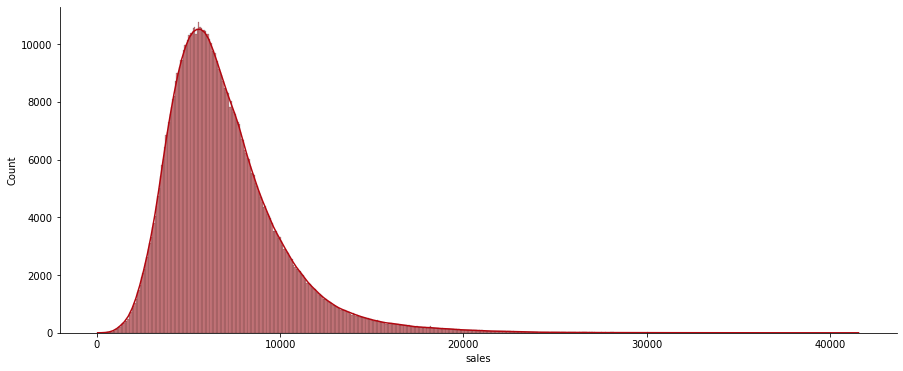

In [42]:
plt.figure(figsize=(15, 6))
sns.histplot(df['sales'], kde=True, color='#b20710')
sns.despine(right=True);

**Insight:** 

As vendas das lojas possuem uma distribuição positiva, levando a concentração dos dados para a esquerda. Isso mostra que, na maioria das lojas as vendas são de valores mais baixos e há menor probabilidade de ter vendas com valores extremos.

### 4.1.2 Variável Numérica

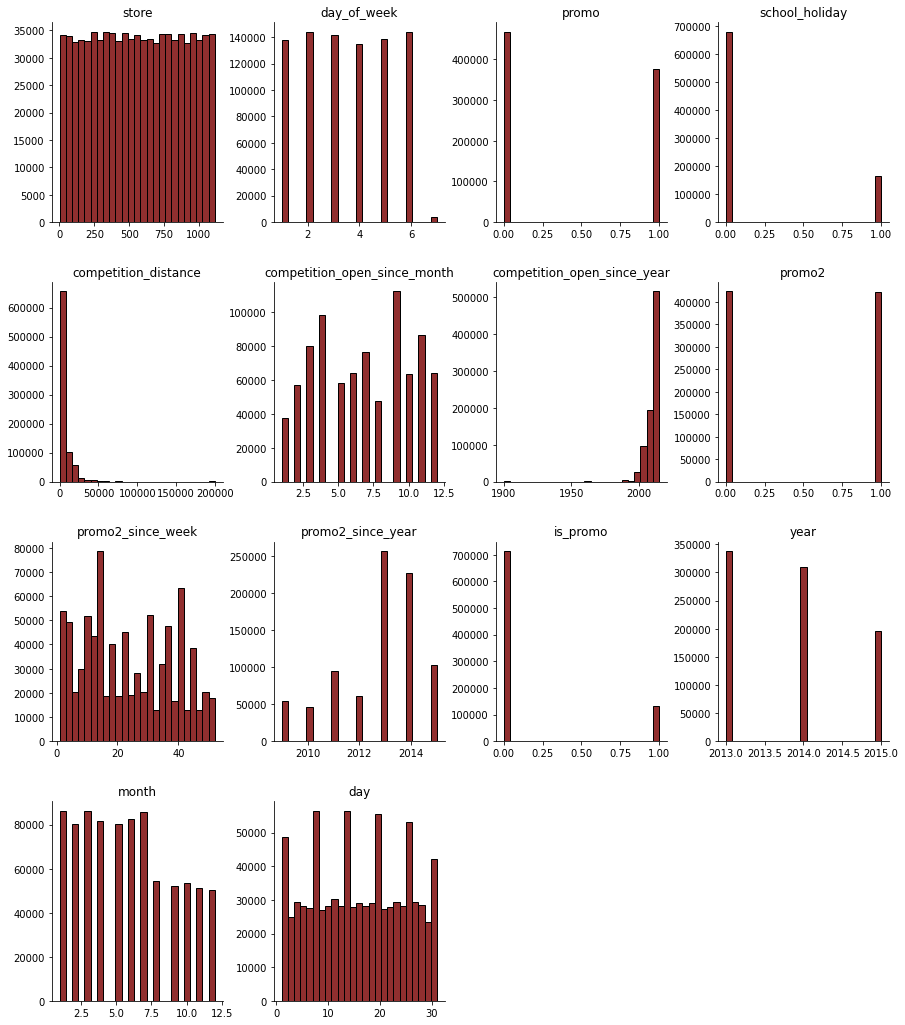

In [43]:
numerical = df.select_dtypes(include=['int64', 'float64']).drop(columns='sales')
numerical.hist(figsize=(15, 18), bins=25, grid=False, ec='k', color='#912f2f')
sns.despine(right=True);

**Insight:**

- Vendas no 7º dia (domingo) vendem menos na semana.

- Em quantidade, as lojas fazem menos promoções.

- A maior parte dos competidores estão mais pertos.

- Os competidores foram abertos em anos mais recentes.

### 4.1.3 Variável Categórica

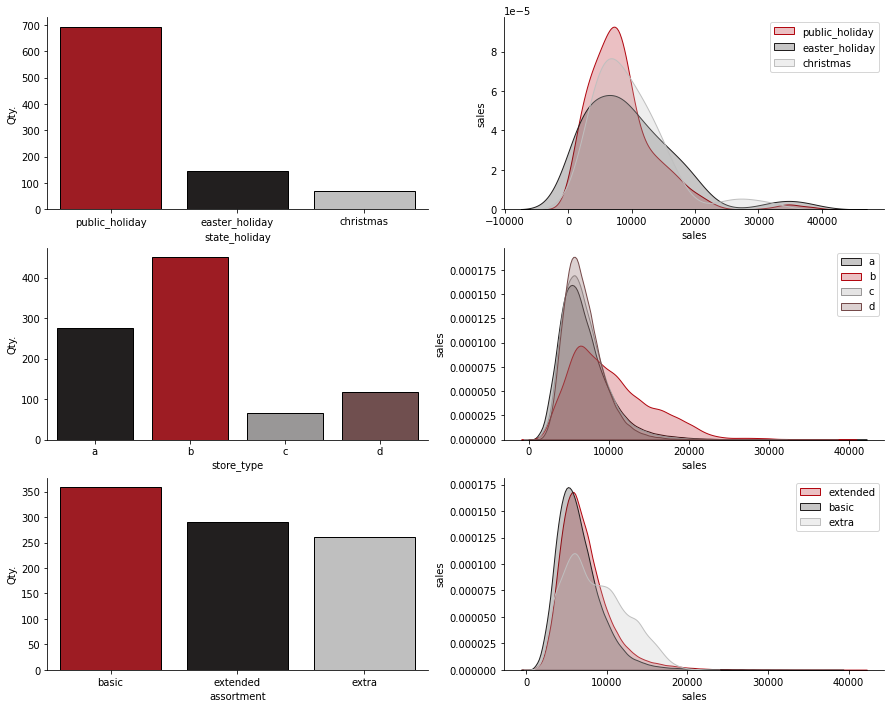

In [44]:
# Filter Categories
categories = df.select_dtypes(include=['object'])

# -- state_holiday
# Figure 1
filter_holiday = categories[categories['state_holiday'] != 'regular_day']
plt.figure(figsize=(15, 12))
plt.subplot(3, 2, 1)
sns.countplot(x='state_holiday', data=filter_holiday, palette=['#b20710', '#221f1f', '#bfbfbf'], ec='k')
plt.ylabel('Qty.')
sns.despine(right=True)

# Figure 2
plt.subplot(3, 2, 2)
sns.kdeplot(x=df[df['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True, color='#b20710')
sns.kdeplot(x=df[df['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True, color='#221f1f')
sns.kdeplot(x=df[df['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True, color='#bfbfbf')
plt.legend()
plt.ylabel('sales')
sns.despine(right=True)

# -- store_type
# Figure 1
plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=filter_holiday, order=['a', 'b', 'c', 'd'], palette=['#221f1f', '#b20710', '#999797', '#754a4a'], ec='k')
sns.despine(right=True)
plt.ylabel('Qty.')

# Figure 2
plt.subplot(3, 2, 4)
sns.kdeplot(x=df[df['store_type'] == 'a']['sales'], label='a', shade=True, color='#221f1f')
sns.kdeplot(x=df[df['store_type'] == 'b']['sales'], label='b', shade=True, color='#b20710')
sns.kdeplot(x=df[df['store_type'] == 'c']['sales'], label='c', shade=True, color='#999797')
sns.kdeplot(x=df[df['store_type'] == 'd']['sales'], label='d', shade=True, color='#754a4a')
plt.legend()
plt.ylabel('sales')
sns.despine(right=True)

# -- assortment
# Figure 1
plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=filter_holiday, ec='k', palette=['#b20710', '#221f1f', '#bfbfbf'])
sns.despine(right=True)
plt.ylabel('Qty.')

# Figure 2
plt.subplot(3, 2, 6)
sns.kdeplot(x=df[df['assortment'] == 'extended']['sales'], label='extended', shade=True, color='#b20710')
sns.kdeplot(x=df[df['assortment'] == 'basic']['sales'], label='basic', shade=True, color='#221f1f')
sns.kdeplot(x=df[df['assortment'] == 'extra']['sales'], label='extra', shade=True, color='#bfbfbf')
plt.ylabel('sales')
sns.despine(right=True)
plt.legend();

**Insight:**

A maior parte dos feriados são públicos, mas feriados de natal e pascoa conseguem atingir vendas com valores mais extremos. Há maior quantidade de lojas do tipo B e também conseguem atingir maiores valores em vendas. A maior parte das lojas possuem assortment do tipo Basic, mas o tipo Extra consegue atingir vendas com valores mais altos.

## 4.2 Análise Bivariada

### H1. Lojas com maior sortimento vendem mais.

**FALSA** Lojas com maior sortmento vendem menos.

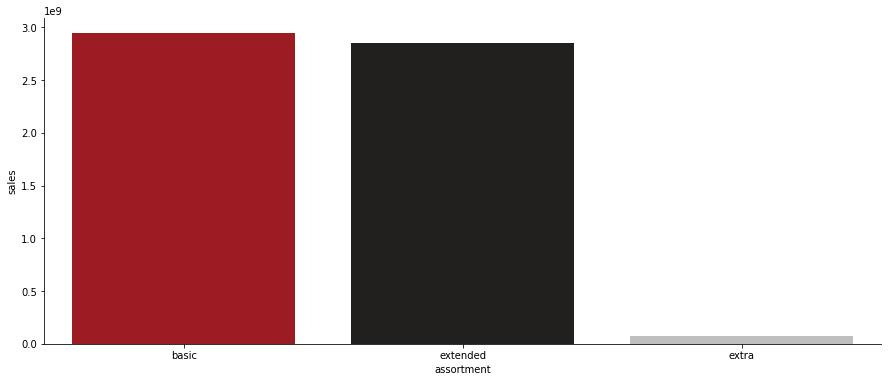

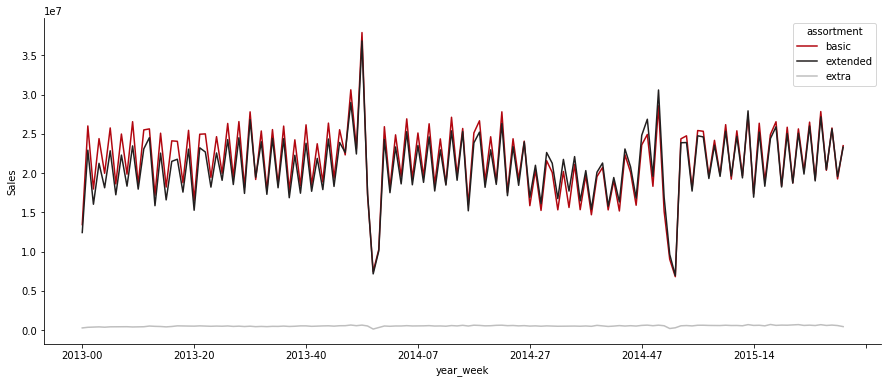

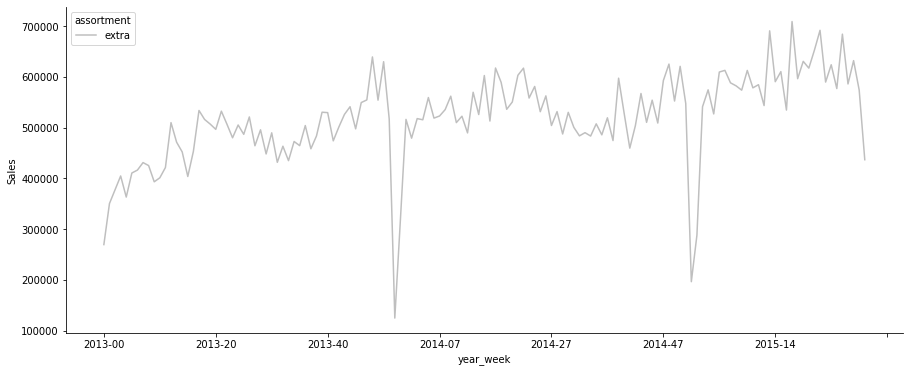

In [45]:
# Filter
filter_1 = df['sales'].groupby(df['assortment']).sum().reset_index()

# Figure 1
plt.figure(figsize=(15, 6))
sns.barplot(x='assortment', y='sales', data=filter_1, palette=['#b20710', '#221f1f', '#bfbfbf'])
sns.despine(right=True)

# Figure 2
filter_2 = df[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
filter_2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(15, 6), color=['#b20710', '#221f1f', '#bfbfbf'])
sns.despine(right=True)
plt.ylabel('Sales')

# Figure 3
filter_3 = filter_2[filter_2['assortment'] == 'extra']
filter_3.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(15, 6), color='#bfbfbf')
sns.despine(right=True)
plt.ylabel('Sales');

### H2. Lojas com competidores mais próximos vendem menos.

**FALSA** Lojas com competidores mais próximos vendem mais.

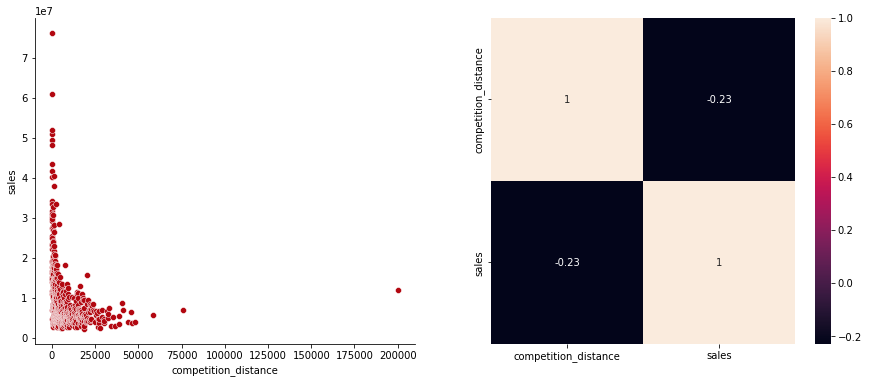

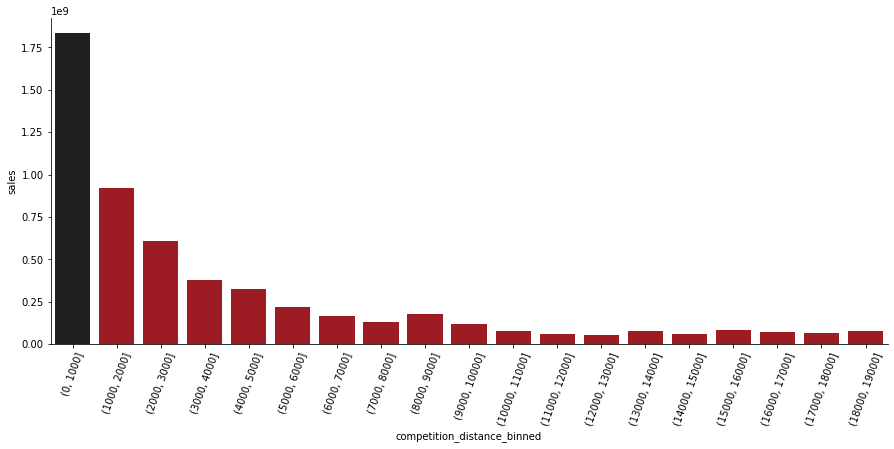

In [77]:
# Filter
filter_h1 = df_raw[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# Figure 1
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='competition_distance', y='sales', data=filter_h1, color='#b20710')
sns.despine(right=True)

# Figure 2
plt.subplot(1, 2, 2)
sns.heatmap(filter_h1.corr(method='pearson'), annot=True)

# Figure 3
plt.figure(figsize=(15, 6))
bins = list(np.arange(0, 20000, 1000)) # Define group
filter_h1['competition_distance_binned'] = pd.cut(filter_h1['competition_distance'], bins=bins) # Group competition
filter_h2 = filter_h1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
colors = list(filter_h2['sales'].apply(lambda x: '#221f1f' if x == 1832415839 else '#b20710'))
sns.barplot(x='competition_distance_binned', y='sales', data=filter_h2, palette=colors)
plt.xticks(rotation=70)
sns.despine(right=True);

### H3.Lojas com competidores à mais tempo vendem mais.

**FALSA** Lojas com competidores à mais tempo vendem menos.

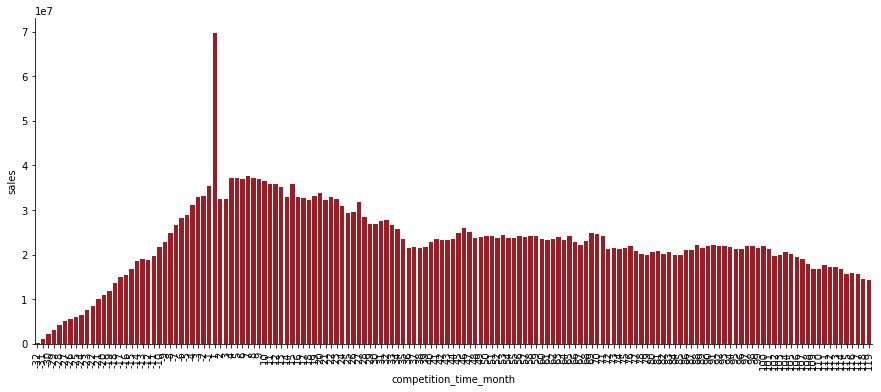

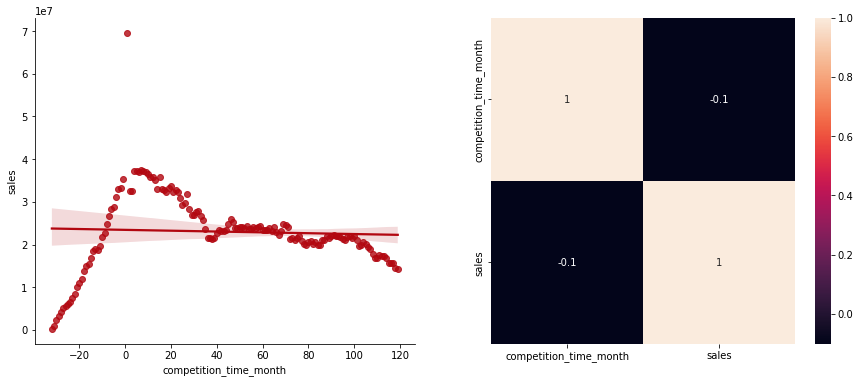

In [20]:
# Filter
filter_h1 = df[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
filter_h2 = filter_h1[(filter_h1['competition_time_month'] < 120) & (filter_h1['competition_time_month'] != 0)]

# Figure 1
plt.figure(figsize=(15, 6))
sns.barplot(x='competition_time_month', y='sales', data=filter_h2, color='#b20710')
plt.xticks(rotation=90)
sns.despine(right=True)

# Figure 2
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.regplot(x='competition_time_month', y='sales', data=filter_h2, color='#b20710')
sns.despine(right=True)

# Figure 3
plt.subplot(1, 2, 2)
sns.heatmap(filter_h1.corr(method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempo vendem mais

**FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.

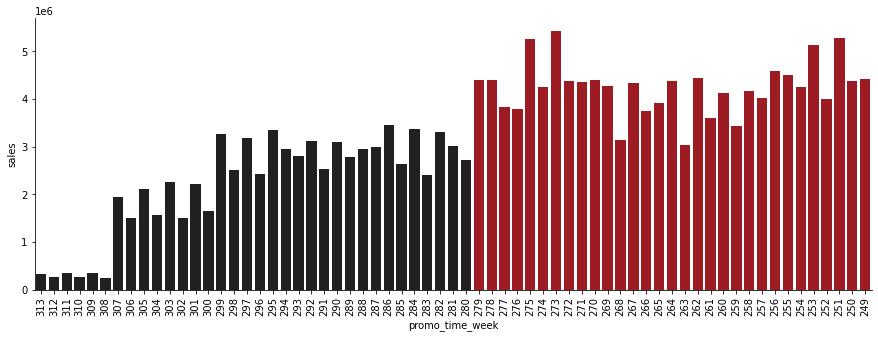

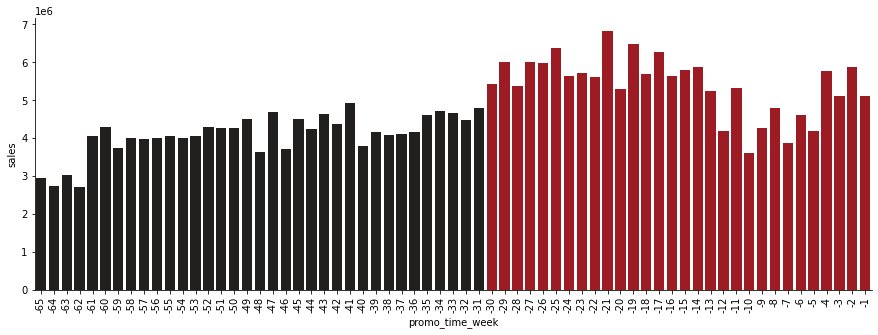

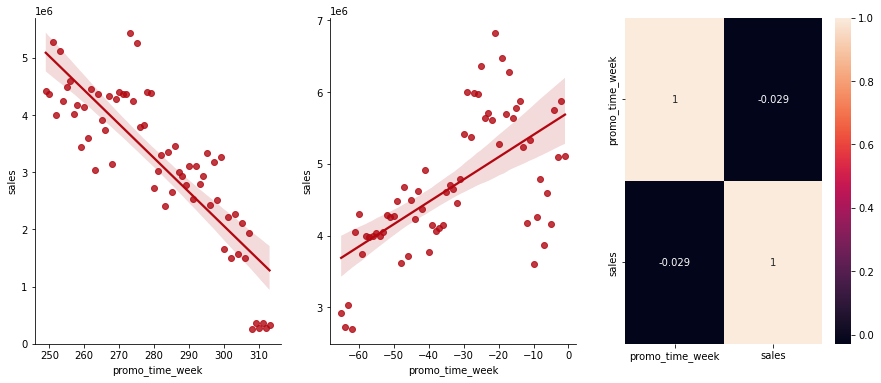

In [135]:
# Filter
filter_h1 = df[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
#grid = gridspec.GridSpec(2, 3) # Adjust figures

# Figure 1
plt.figure(figsize=(15, 5))
extended = filter_h1[filter_h1['promo_time_week'] > 0]
extended = extended[['promo_time_week', 'sales']].sort_values(by='promo_time_week', ascending=False)[:65]
colors = list(extended['promo_time_week'].apply(lambda x: '#221f1f' if x > 279 else '#b20710'))
sns.barplot(x='promo_time_week', y='sales', data=extended, order=extended['promo_time_week'].sort_values(ascending=False).values, palette=colors)
plt.xticks(rotation=90)
sns.despine(right=True)


# Figure 2
plt.figure(figsize=(15, 5))
regular = filter_h1[filter_h1['promo_time_week'] < 0].sort_values(by='promo_time_week', ascending=False)[:65]
colors = list(regular['promo_time_week'].apply(lambda x: '#221f1f' if int(x) > -36 else '#b20710'))
sns.barplot(x='promo_time_week', y='sales', data=regular, palette=colors)
plt.xticks(rotation=90)
sns.despine(right=True)

# Figure 3
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
sns.regplot(x='promo_time_week', y='sales', data=extended, color='#b20710')
sns.despine(right=True)

# Figure 4
plt.subplot(1, 3, 2)
sns.regplot(x='promo_time_week', y='sales', data=regular, color='#b20710')
sns.despine(right=True)

# Figure 5
plt.subplot(1, 3, 3)
sns.heatmap(filter_h1.corr(method='pearson'), annot=True);

### H5. Lojas com mais promoções consecutivas vendem mais.

**FALSA** Lojas com mais promocões consecutivas vendem menos.

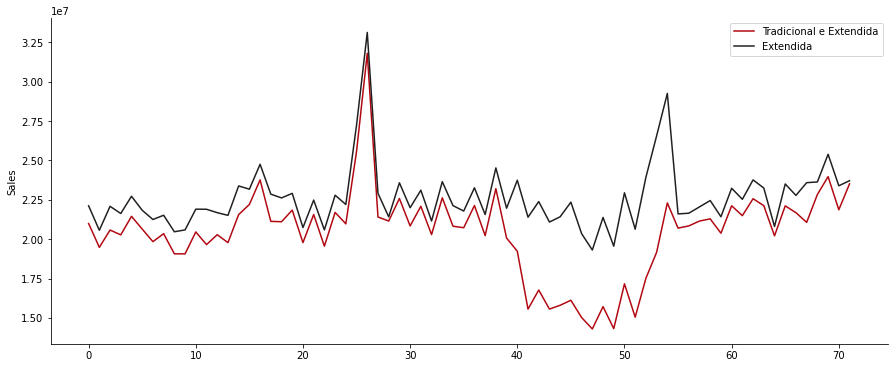

In [22]:
# Filter
filter_1 = df[(df['promo'] == 1) & (df['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
filter_2 = df[(df['promo'] == 1) & (df['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()

# Figure
ax = filter_1.plot(color='#b20710') # Line 1
filter_2.plot(ax=ax, figsize=(15, 6), color='#221f1f') # Line 2
ax = plt.legend(labels=['Tradicional e Extendida', 'Extendida']) # Legend figure
sns.despine(right=True)
plt.ylabel('Sales');

### H6. Lojas abertas durante o feriado de Natal vendem mais.

**FALSA** Lojas abertas durante o feriado de Natal vendem menos.

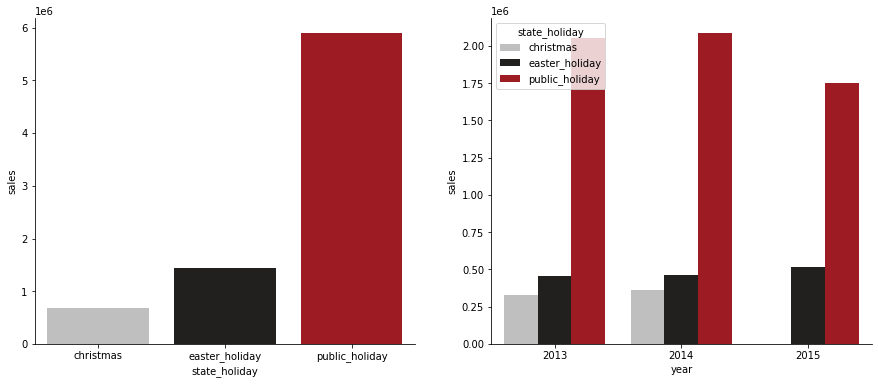

In [23]:
# Filter
filter_1 = df[df['state_holiday'] != 'regular_day']
filter_h2 = filter_1[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

# Figure 1
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='state_holiday', y='sales', data=filter_h2, palette=['#bfbfbf', '#221f1f', '#b20710'])
sns.despine(right=True)

# Figure 2
plt.subplot(1, 2, 2)
filter_3 = filter_1[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', data=filter_3, hue='state_holiday', palette=['#bfbfbf', '#221f1f', '#b20710'])
sns.despine(right=True);

### H7. Lojas vendem mais ao longo dos anos.

**FALSA** Lojas vendem menos ao longo dos anos.

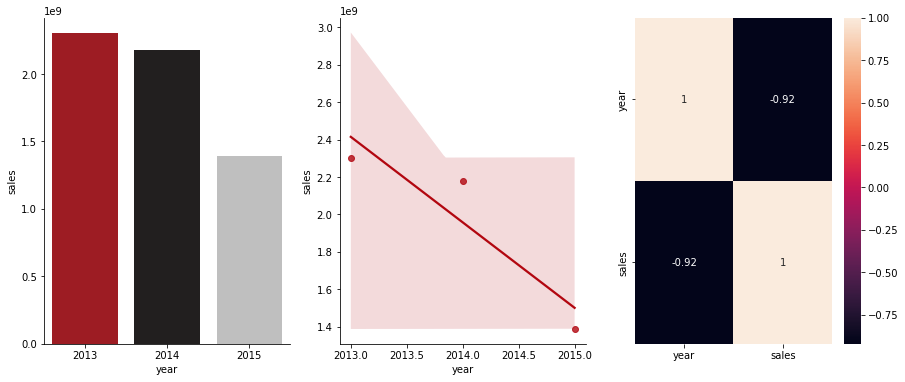

In [24]:
# Filter
filter_h1 = df[['year', 'sales']].groupby('year').sum().reset_index()

# Figure 1
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=filter_h1, palette=['#b20710', '#221f1f', '#bfbfbf'])
sns.despine(right=True)

# Figure 2
plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=filter_h1, color='#b20710')
sns.despine(right=True)

# Figure 3
plt.subplot(1, 3, 3)
sns.heatmap(filter_h1.corr(method='pearson'), annot=True);

### H8.Lojas vendem mais no segundo semestre do ano.

**FALSA** Lojas vendem menos no segundo semestre do ano.

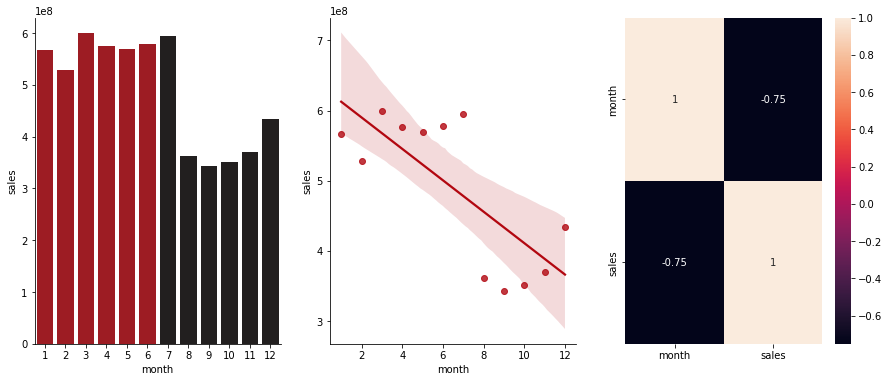

In [25]:
# Filter
filter_h1 = df[['month', 'sales']].groupby('month').sum().reset_index()

# Custom color to visuzalition
custom_color = []

for v in filter_h1['month']:
    if v <= 6:
        custom_color.append('#b20710')
    else:
        custom_color.append('#221f1f')

# Figure 1
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=filter_h1, palette=custom_color)
sns.despine(right=True)

# Figure 2
plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=filter_h1, color='#b20710')
sns.despine(right=True)

# Figure 3
plt.subplot(1, 3, 3)
sns.heatmap(filter_h1.corr(method='pearson'), annot=True);

### H9. Lojas vendem mais depois do dia 10 de cada mês.

**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês.

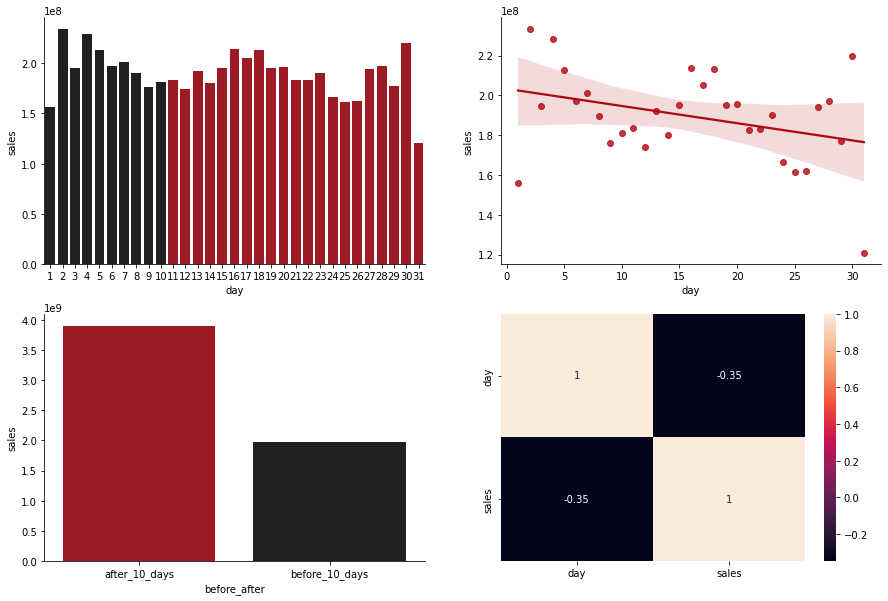

In [26]:
# Filter
filter_h1 = df[['day', 'sales']].groupby('day').sum().reset_index()
custom_color = []

# Custom color to visuzalition
for v in filter_h1['day']:
    if v <= 10:
        custom_color.append('#221f1f')
    else:
        custom_color.append('#b20710')

# Figure 1
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=filter_h1, palette=custom_color)
sns.despine(right=True)

# Figure 2
plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=filter_h1, color='#b20710')
sns.despine(right=True)

# Figure 3
plt.subplot(2, 2, 3)
filter_h1['before_after'] = filter_h1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
filter_h2 = filter_h1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=filter_h2, palette=['#b20710', '#221f1f'])
sns.despine(right=True)

# Figure 4
plt.subplot(2, 2, 4)
sns.heatmap(filter_h1.corr(method='pearson'), annot=True);

### H10. Lojas vendem menos aos finais de semana.

**VERDADEIRA** Lojas vendem menos aos finais de semana.

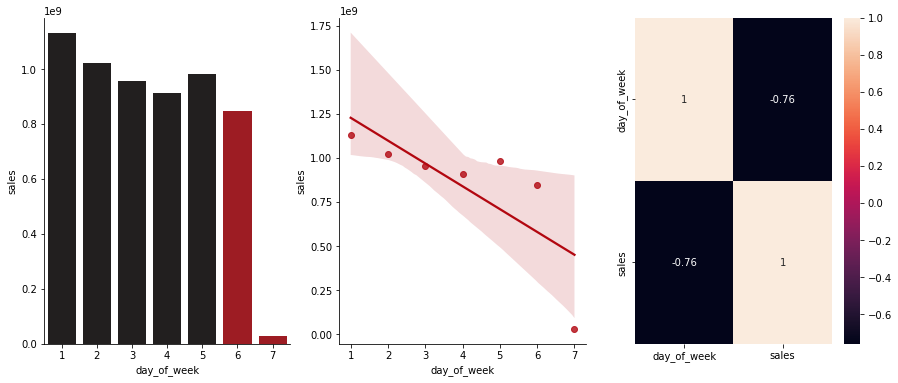

In [27]:
# Filter
filter_h1 = df[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

# Figure 1
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=filter_h1, palette=['#221f1f', '#221f1f', '#221f1f', '#221f1f', '#221f1f', '#b20710', '#b20710'])
sns.despine(right=True)

# Figure 2
plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=filter_h1, color='#b20710')
sns.despine(right=True)

# Figure 3
plt.subplot(1, 3, 3)
sns.heatmap(filter_h1.corr(method='pearson'), annot=True);

### H11. Lojas vendem menos durante os feriados escolares.

**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

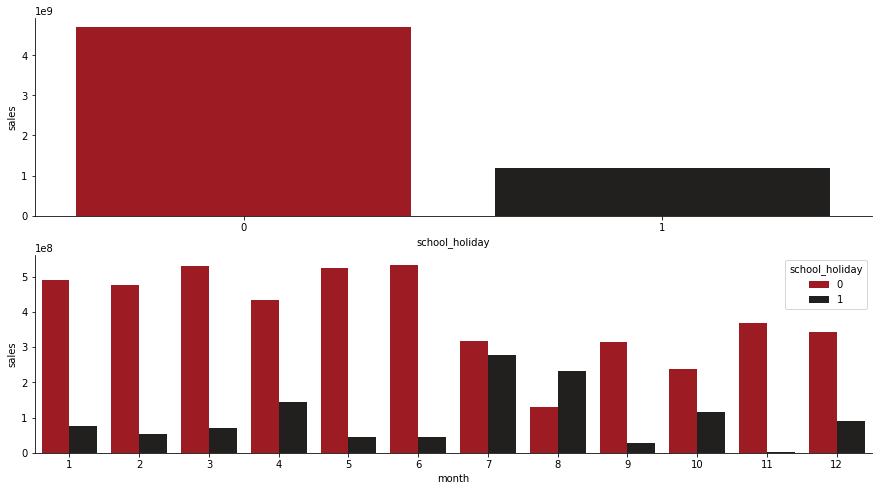

In [28]:
# Filter
filter_h1 = df[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

# Figure 1
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=filter_h1, palette=['#b20710', '#221f1f'])
sns.despine(right=True)

# Figure 2
plt.subplot(2, 1, 2)
filter_h2 = df[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=filter_h2, palette=['#b20710', '#221f1f'])
sns.despine(right=True);

## 4.3 Análise Multivariada

### 4.3.1 Variável Numérica

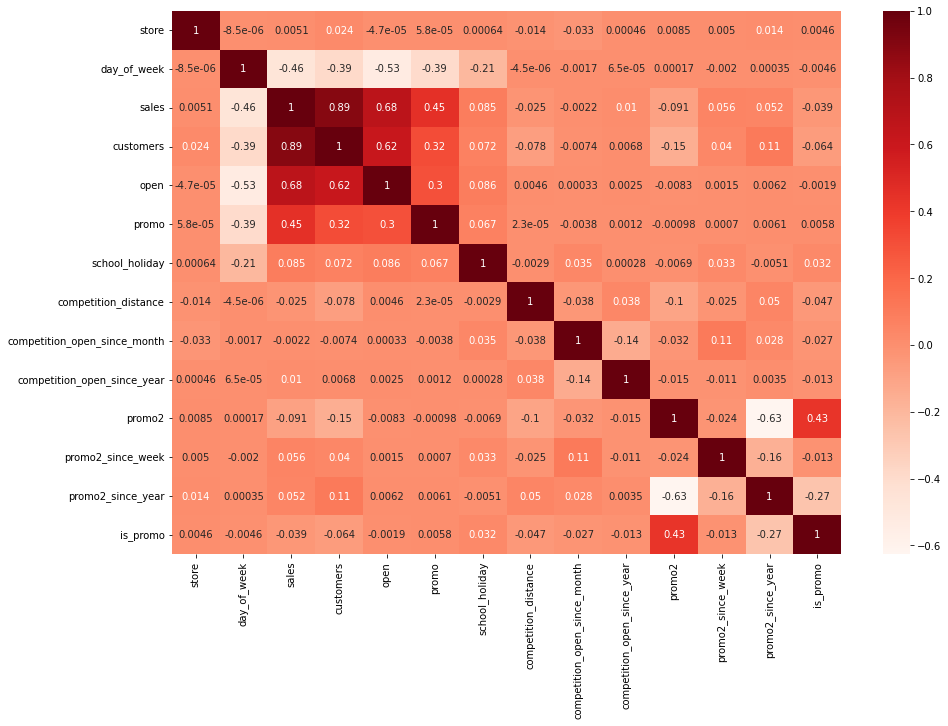

In [29]:
# Correlation numerical variable
plt.figure(figsize=(15, 10))
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True, cmap='Reds');

**Insight:**

Nas váriaveis numéricas, há uma correlação forte da variavel reposta Sales com day_of_week (dia da semana), customers (clientes) e open. Em outras variaveis, há correlação entre promo e day_of_week, day_of_week com school_day, promo e com open.

### 4.3.2 Variável Categórica

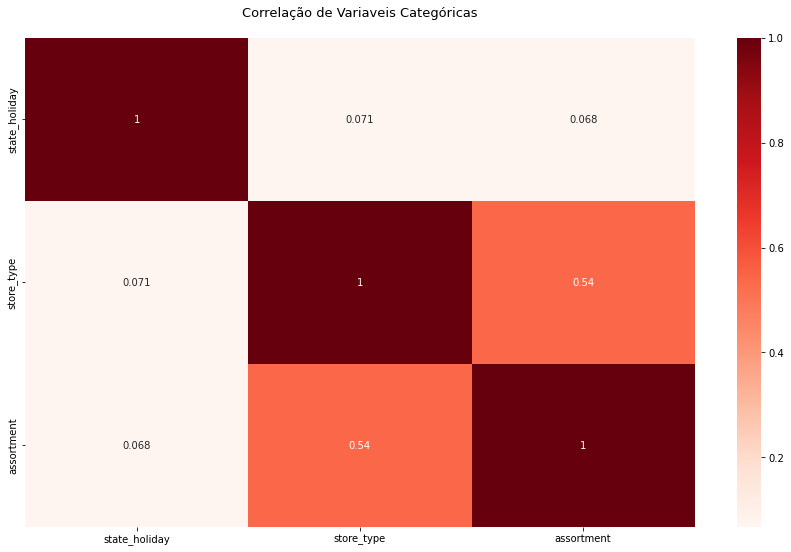

In [30]:
# Categorical data
categories = df[['state_holiday', 'store_type', 'assortment']]

# Apply correlation categories
matrix = show_matrix(data=categories, col='state_holiday', output='dict')
data_columns = categories.iloc[:, 1:]

for c in data_columns.columns:
    matrix[c] = show_matrix(data=categories, col=c, output='list')

# Figure
plt.figure(figsize=(15, 9))
sns.heatmap(matrix, annot=True, cmap='Reds')
plt.title('Correlação de Variaveis Categóricas\n', fontsize=13);

**Insight:**

Nas variaveis categóricas, há fraca correlação com state_holiday (feriado estadual) e store_type (tipo daloja). E store_type possui uma correlação forte com assortment (sortimento).

# 5.0 PREPARAÇÃO DE DADOS

## 5.1 Rescaling

In [31]:
df2 = df.copy() # Copy data

rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df2['competition_distance'] = rs.fit_transform(df2[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))


# competition time month
df2['competition_time_month'] = rs.fit_transform(df2[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))


# promo time week
df2['promo_time_week'] = mms.fit_transform(df2[['promo_time_week']].values)
pickle.dump(rs, open('parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df2['year'] = mms.fit_transform(df2[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

## 5.2 Transformação

### 5.2.1 Encoding

In [32]:
# state_holiday - One Hot Encoding
df2 = pd.get_dummies(df2, prefix=['state_holiday'], columns=['state_holiday'])


# store_type - Label Encoder
le = LabelEncoder()
df2['store_type'] = le.fit_transform(df2['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))


# assortment - Ordinal Encoder
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df2['assortment'] = df2['assortment'].map(assortment_dict)

### 5.2.2 Transformação de Variável Resposta

In [33]:
# Apply log to transformation in sales
df2['sales'] = np.log(df2['sales'])

### 4.2.3 Tranformação de Natureza

In [34]:
# day_of_week
df2['day_of_week_sin'] = df2['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
df2['day_of_week_cos'] = df2['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))


# month
df2['month_sin'] = df2['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df2['month_cos'] = df2['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))


# day
df2['day_sin'] = df2['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
df2['day_cos'] = df2['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))


# week_of_year
df2['week_of_year_sin'] = df2['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
df2['week_of_year_cos'] = df2['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

# 6.0 SELEÇÃO DE FEATURE

## 6.1 Divisão de Dados

In [35]:
# Copy data
df3 = df2.copy()

# Drop columns as they have been replaced by new variables
cols_drop = ['week_of_year', 'day_of_week', 'day', 'month', 'promo_since', 'competition_since', 'year_week']
df3 = df3.drop(columns=cols_drop)

In [36]:
# Search date: 6 week
date_hour = df3[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)    
date = str(date_hour)[:10]

# Training dataset
X_train = df3[df3['date'] < date]
Y_train = X_train['sales']

# Test dataset
X_test = df3[df3['date'] >= date]
Y_test = X_test['sales']

print(f"Training Min Date: {X_train['date'].min()}")
print(f"Training Max Date: {X_train['date'].max()}")

print(f"\nTest Min Date: {X_test['date'].min()}")
print(f"Test Min Date: {X_test['date'].max()}")

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Min Date: 2015-07-31 00:00:00


## 6.2 Boruta para Seleção de Feature

In [ ]:
# Training and test dataset for Boruta
X_train_n = X_train.drop(columns=['date', 'sales']).values
Y_train_n = Y_train.values.ravel()

# Define Random Forest
rf = RandomForestRegressor(n_jobs=1)

# Define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, Y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0


### 6.2.1 Melhores Features do Boruta

In [ ]:
# Selected Boruta
cols_selected = boruta.support_.tolist()

# Best Features
X_train_fs = X_train.drop(columns=['date', 'sales'])
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()


# Not Selected Boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

### 6.2.2 Manual Seleção de Feature

In [37]:
# Result columns select Boruta
cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
                        'competition_open_since_month', 'competition_open_since_year', 'promo2',
                        'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                        'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 
                        'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']

# Add columns
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 MODELAGEM DE MACHINE LEARNING

In [38]:
# Split train and test to machine learning
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

x_training = X_train[cols_selected_boruta_full] 

## 7.1 Modelo de Média

In [39]:
# Copy data
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# Prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800167,0.206441,1835.141019


## 7.2 Modelo de Regressão Linear

In [61]:
# Model
lr = LinearRegression().fit(x_train, Y_train)

# Prediction
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.086951,0.292756,2671.056821


### 7.2.1 Regressão Linear - Cross Validation

In [62]:
# Apply function to start Cross Validation
lr_result_cv = cross_validation(x_training, kfold=5, model_name='Linear Regression', model=lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1995.05 +/- 45.55,0.3 +/- 0.01,2847.67 +/- 97.29


## 7.3 Modelo de Regressão Linear Regularizada - Lasso

In [63]:
# Model
lrr = Lasso(alpha=0.01).fit(x_train, Y_train)

# Prediction
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.702084,0.289165,2744.462517


### 7.3.1 Regressão Linear Regularizada  Lasso - Cross Validation

In [64]:
# Apply function to start Cross Validation
lrr_result_cv = cross_validation(x_training, kfold=5, model_name='Lasso', model=lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2035.93 +/- 60.74,0.29 +/- 0.0,2965.25 +/- 101.42


## 7.4 Random Forest Regressor

In [65]:
# Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, Y_train)

# Prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.948666,0.099899,1010.055097


### 7.4.1 Random Forest - Cross Validation

In [66]:
# Apply function to start Cross Validation
rf_result_cv = cross_validation(x_training, kfold=5, model_name='Random Forest', model=rf)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,834.77 +/- 105.53,0.12 +/- 0.02,1275.72 +/- 193.23


## 7.5 XGBoost Regressor

In [67]:
# Model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, Y_train)

# Prediction
yhat_xgb = model_xgb.predict(x_test)

# Performance
xgb_result = ml_error('RGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,RGBoost Regressor,889.472555,0.129715,1303.819024


### 7.5.1 XGBoost Regressor - Cross Validation 

In [68]:
# Apply function to start Cross Validation
xgb_result_cv = cross_validation(x_training, kfold=5, model_name='XGBoost', model=model_xgb)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,1059.45 +/- 60.95,0.14 +/- 0.01,1543.4 +/- 99.71


## 7.6 Comparação de Performace dos Modelos

### 7.6.1 Performace

In [69]:
# Comparing performance with all models
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])

# Sort result by RMSE
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.948666,0.099899,1010.055097
0,RGBoost Regressor,889.472555,0.129715,1303.819024
0,Average Model,1354.800167,0.206441,1835.141019
0,Linear Regression,1867.086951,0.292756,2671.056821
0,Linear Regression - Lasso,1891.702084,0.289165,2744.462517


### 7.6.2 Performace Real - Cross Validation

In [71]:
# Comparing performance with all models and with cross validation
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])

# Sort result by RMSE
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1995.05 +/- 45.55,0.3 +/- 0.01,2847.67 +/- 97.29
0,Lasso,2035.93 +/- 60.74,0.29 +/- 0.0,2965.25 +/- 101.42
0,Random Forest,834.77 +/- 105.53,0.12 +/- 0.02,1275.72 +/- 193.23
0,XGBoost,1059.45 +/- 60.95,0.14 +/- 0.01,1543.4 +/- 99.71


**Insight:**

Olhando para a métrica RMSE, como forma de medir quão bem o modelo está, o Algoritmo de Random Forest e o XGboost conseguem compreender melhor o fenomeno e comportamento da previsão de vendas da Rossmann. O Random Forest ainda é o melhor, mas para este problema será usado o XGboost, devido a Random Forest precisar de muito processamento computacional e as comparações das métricas estarem próximas.

# 8.0 AJUSTE DE HIPERPARAMETROS

## 8.1 Random Search

In [72]:
# Params XGboost to Random Search
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 5
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # choose values for parameters randomly
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)
    
    # Model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                min_child_weight=hp['min_child_weight'])


    # Performance
    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb)
    final_result = pd.concat([final_result, result])
    
final_result

{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,828.5 +/- 53.58,0.12 +/- 0.0,1166.43 +/- 98.29
0,XGBoost Regressor,835.42 +/- 60.18,0.12 +/- 0.01,1180.77 +/- 101.07
0,XGBoost Regressor,798.36 +/- 68.05,0.11 +/- 0.01,1141.03 +/- 118.65
0,XGBoost Regressor,877.72 +/- 72.78,0.12 +/- 0.01,1232.32 +/- 121.45
0,XGBoost Regressor,843.68 +/- 61.5,0.12 +/- 0.01,1184.94 +/- 107.69


## 8.2 Modelo Final

In [40]:
# Parameter result in Random Search
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.5,
    'colsample_bytree': 0.7,
    'min_child_weight': 8
}


# Model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, Y_train)


# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# Performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned))

# Add metric MPE
mpe = mean_percentage_error(np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned['MPE'] = mpe

xgb_result_tuned

,Model Name,MAE,MAPE,RMSE,MPE
0,XGBoost Regressor,670.761437,0.098141,969.43429,0.002759


**Insight:**

O modelo final possui um erro de 9%, isso equiavale a um valor em vendas de 670k.

# 9.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO

## 9.1 Performace do Negócio

In [41]:
df9 = X_test[cols_selected_boruta_full]

# Rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

# Sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE | MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenatios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']


# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]
df92.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
523,524,321999.125000,321510.310433,322487.939567,488.814567,0.069453
226,227,221946.562500,221550.341850,222342.783150,396.220650,0.069652
830,831,452372.906250,451502.098765,453243.713735,870.807485,0.078171
952,953,202348.296875,201947.753662,202748.840088,400.543213,0.082776
738,739,393416.968750,392422.655511,394411.281989,994.313239,0.093148


**Insight:**

Facilitando a tomada de decisão, o CFO pode observar os possíveis cenarios para uma amostra de 5 lojas, a loja de código 524 tem a previsão de 321k de vendas para as próximas 6 semanas com um erro de 7%, isso representa um erro de 488 em vendas. No melhor cenario, a loja 524 venderá 322k e no pior 321k em vendas. O CFO pode visualizar os cenarios para todas as lojas ajudando na hora de definir o budgte das lojas.

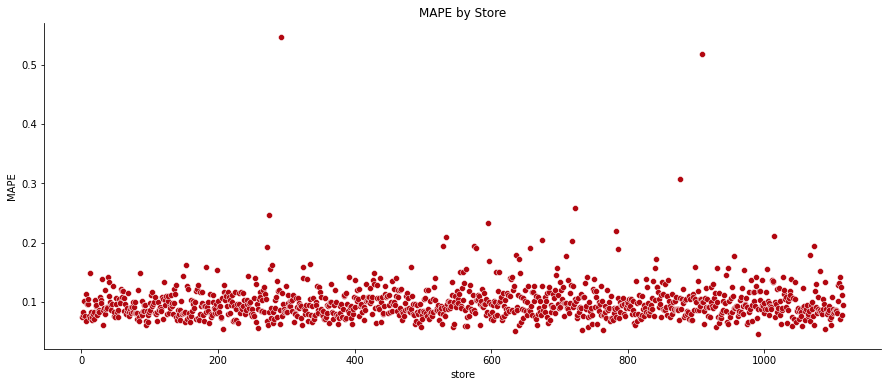

In [42]:
# Figure
plt.figure(figsize=(15, 6))
sns.scatterplot(x='store', y='MAPE', data=df92, color='#b20710')
sns.despine(right=True)
plt.title('MAPE by Store');

**Insight:**

Em média, o modelo está errando em 10%. Há ainda casos em que o modelo erra mais, como no caso de 2 lojas em que o modelo está obtendo um erro maior que 50%, isso mostra que existem lojas mais desafiadoras do que outras.

## 9.2 Performace Total

In [43]:
# Sum result scenario
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(
    lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenarios', 0: 'Values'}
)

# Add value in R$
df93['Values'] = df93['Values'].map('R${:,.2F}'.format)
df93

,Scenarios,Values
0,predictions,"R$284,340,672.00"
1,worst_scenario,"R$283,589,141.12"
2,best_scenario,"R$285,092,268.18"


**Insight:**

Para as vendas totais, a predição das próximas 6 semanas de todas as lojas é de 284M. No pior cenário, as vendas será de 283M e no melhor, será de 285M.

## 9.3 Performace do Modelo

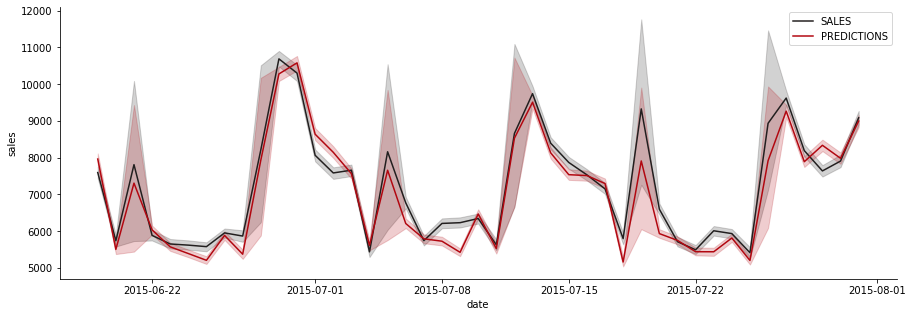

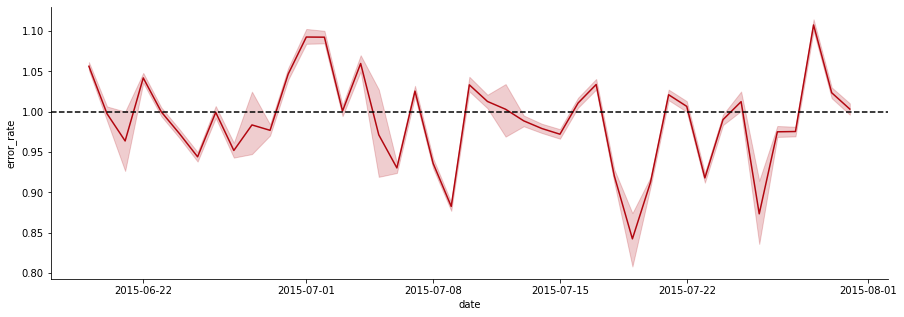

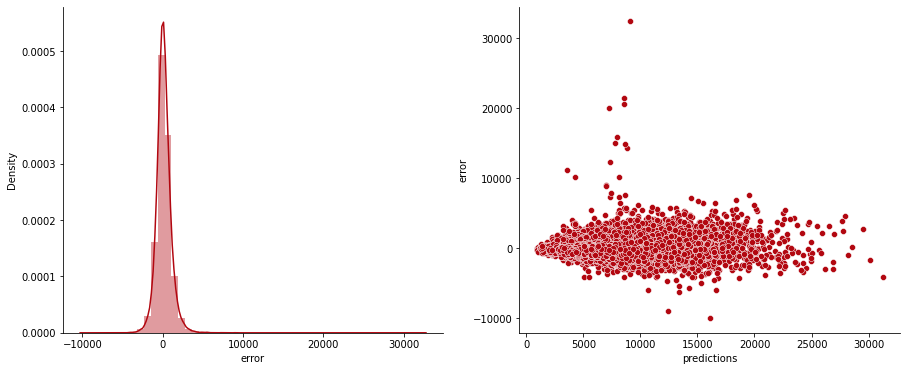

In [44]:
# Create error columns 
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales'];

# Figure 1
plt.figure(figsize=(15, 5))
sns.lineplot(x='date', y='sales', data=df9, label='SALES', color='#221f1f')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS', color='#b20710')
sns.despine(right=True)

# Figure 2
plt.figure(figsize=(15, 5))
sns.lineplot(x='date', y='error_rate', data=df9, color='#b20710')
plt.axhline(1, linestyle='--', color='k')
sns.despine(right=True)

# Figure 3
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.distplot(df9['error'], color='#b20710')
sns.despine(right=True)
             
# Figure 4    
plt.subplot(1, 2, 2)
sns.scatterplot(x='predictions', y='error', data=df9, color='#b20710')
sns.despine(right=True);

**Insight:**

Com os 4 gráficos acima, é possível visualizar as vendas em comparação com a predição ao longo das semanas, a predição está bem próxima das vendas seguindo o mesmo comportamento e ainda é possível observar em quais dias da semana possuem o maior erro. E é possível observar que o modelo está subestimando mais ao longo do tempo e que a distribuição dos erros está próxima de uma distribuição normal, estão bem distribuidos. E ainda, podemos observar os resíduos, sempre que o modelo faz previsões entre 8k e 10k há erros maiores. No geral, os residuos estão concentrados e isso é bom.

# 10.0 DEPLOY DO MODELO EM PRODUÇÃO

## 10.1 Salvar Modelo Final

In [45]:
# Save Trained Model
pickle.dump(model_xgb_tuned, open('C:/Users/Jhonatans/projects/ML/Regression/Rossmann-Sales-Forecast/model/model_rossmann.pkl', 'wb'))

## 10.2 Modelo em Produção

Acessar [aqui](https://t.me/model_rossmann_bot) os resultados do modelo em prdução.